# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Sulu Edward Julianto
- **Email:** sulujulianto@gmail.com
- **ID Dicoding:** sulujulianto

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip -q install kagglehub tensorflowjs==4.20.0

import os, shutil, random, pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

print("TensorFlow:", tf.__version__)
seed = 42
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Download dataset Intel Image Classification
import kagglehub
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Dataset path:", path)

TensorFlow: 2.19.0
Using Colab cache for faster access to the 'intel-image-classification' dataset.
Dataset path: /kaggle/input/intel-image-classification


## Data Preparation

### Data Loading

In [3]:
# Gabungkan train & test asli agar bisa split sendiri
orig_train = os.path.join(path, "seg_train", "seg_train")
orig_test  = os.path.join(path, "seg_test",  "seg_test")

base_dir = "/content/intel_dataset_selfsplit"
all_dir  = os.path.join(base_dir, "all")
os.makedirs(all_dir, exist_ok=True)

def copy_tree(src):
    for cls in os.listdir(src):
        scls = os.path.join(src, cls)
        if not os.path.isdir(scls): continue
        dcls = os.path.join(all_dir, cls)
        os.makedirs(dcls, exist_ok=True)
        for f in os.listdir(scls):
            shutil.copy(os.path.join(scls,f), os.path.join(dcls,f))

copy_tree(orig_train)
copy_tree(orig_test)

print("Semua gambar digabung di:", all_dir)
print("Total kelas:", os.listdir(all_dir))

Semua gambar digabung di: /content/intel_dataset_selfsplit/all
Total kelas: ['street', 'mountain', 'sea', 'forest', 'glacier', 'buildings']


### Data Preprocessing

#### Split Dataset

In [4]:
# Stratified split: 70% train, 20% val, 10% test
from sklearn.model_selection import train_test_split

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

for d in [train_dir, val_dir, test_dir]:
    shutil.rmtree(d, ignore_errors=True)
    for cls in os.listdir(all_dir):
        os.makedirs(os.path.join(d, cls), exist_ok=True)

# Ambil semua file & label
image_paths, labels = [], []
for cls in os.listdir(all_dir):
    for f in os.listdir(os.path.join(all_dir, cls)):
        image_paths.append(os.path.join(all_dir, cls, f))
        labels.append(cls)

X = np.array(image_paths)
y = np.array(labels)

# Split berlapis (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=seed)

def move_files(X, y, target_dir):
    for p, lbl in zip(X, y):
        shutil.copy(p, os.path.join(target_dir, lbl, os.path.basename(p)))

move_files(X_train, y_train, train_dir)
move_files(X_val,   y_val,   val_dir)
move_files(X_test,  y_test,  test_dir)

print("Dataset berhasil di-split.")

Dataset berhasil di-split.


## Modelling

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (150,150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.15,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen   = val_datagen.flow_from_directory(val_dir,   target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_gen  = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

model = Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=callbacks)
test_loss, test_acc = model.evaluate(test_gen)
print(f"Akurasi data test: {test_acc*100:.2f}%")

Found 11923 images belonging to 6 classes.
Found 3424 images belonging to 6 classes.
Found 1687 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 739s 2s/step - accuracy: 0.5052 - loss: 3.5055 - val_accuracy: 0.3443 - val_loss: 4.9614 - learning_rate: 5.0000e-04
Epoch 2/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 751s 2s/step - accuracy: 0.6132 - loss: 1.5136 - val_accuracy: 0.6405 - val_loss: 1.3277 - learning_rate: 5.0000e-04
Epoch 3/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.6555 - loss: 1.0140 - val_accuracy: 0.6364 - val_loss: 1.7044 - learning_rate: 5.0000e-04
Epoch 4/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.7025 - loss: 0.8470 - val_accuracy: 0.7523 - val_loss: 0.7790 - learning_rate: 5.0000e-04
Epoch 5/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.7248 - loss: 0.7939 - val_accuracy: 0.5315 - val_loss: 2.4531 - learning_rate: 5.0000e-04
Epoch 6/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.7281 - loss: 0.7812 - val_accuracy: 0.7821 - val_loss: 0.7007 - learning_rate: 5.0000e-04
Epoch 7/25
373/373 ━━━━━━━━━━━━━━━━━━━━ 724s 2s/step - acc

## Evaluasi dan Visualisasi

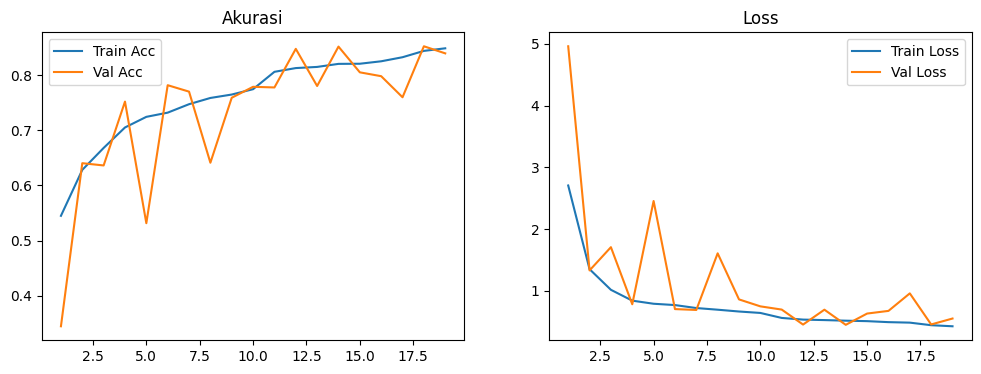

In [6]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.legend(); plt.title('Akurasi')
plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

## Konversi Model

In [8]:
import tensorflowjs as tfjs
os.makedirs("submission", exist_ok=True)

# SavedModel
os.makedirs("submission/saved_model", exist_ok=True)
model.save("submission/saved_model/my_model.keras")
print("✅ SavedModel tersimpan.")

# TF Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("submission/model.tflite","wb") as f: f.write(tflite_model)
print("✅ Model TFLite tersimpan.")

# TFJS
os.makedirs("submission/tfjs_model", exist_ok=True)
tfjs.converters.save_keras_model(model, "submission/tfjs_model")
print("✅ Model TFJS tersimpan.")

✅ SavedModel tersimpan.
Saved artifact at '/tmp/tmpbvbdm8m7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139105712952464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712954192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712953616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712955920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712955152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712955728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712954960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712955536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712951312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139105712957648: TensorSpec(shape=(), dtype=tf.resource, nam

✅ Model TFLite tersimpan.
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model TFJS tersimpan.


## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


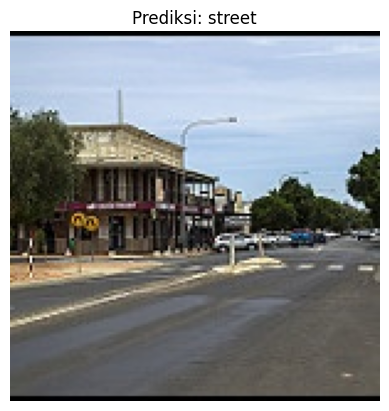

Prediksi label: street


In [9]:
from tensorflow.keras.preprocessing import image

sample_img_path = os.path.join(test_dir, os.listdir(test_dir)[0],
                               os.listdir(os.path.join(test_dir, os.listdir(test_dir)[0]))[0])

img = image.load_img(sample_img_path, target_size=img_size)
img_array = image.img_to_array(img)/255.
img_array = np.expand_dims(img_array, 0)

pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
label = list(train_gen.class_indices.keys())[class_idx]

plt.imshow(image.load_img(sample_img_path))
plt.title(f"Prediksi: {label}")
plt.axis("off")
plt.show()
print("Prediksi label:", label)